# CPS 4801 Final Project: Skin Cancer Classification Using Deep Learning
Names: Leandro Perez, James Ford

Semester: Spring 2025

Department: Computer Science

Instructor: Kuan Huang

# Project Overview
In this project, we develop a deep learning-based classification system to detect skin cancer using dermatoscopic images. We compare an existing model (MobileNetV2) with a custom enhancement (EfficientNetB0) and evaluate their performance using metrics like accuracy, precision, and recall.


# Dataset Overview
Dataset Source: Skin Cancer - Malignant vs Benign (Kaggle)

Total images: ~3,000+

Classes: Benign (non-cancerous), Malignant (cancerous)

Format: High-resolution JPEG images categorized in folders

## 1. Environment Setup

In [4]:

# Install necessary packages
!pip install -q tensorflow matplotlib scikit-learn opencv-python seaborn
!pip install -q opencv-python-headless scikit-image

## 2. Mount Google Drive & Load Data

In [5]:
import kagglehub

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

Mounted at /content/drive
Path to dataset files: /kaggle/input/skin-cancer-malignant-vs-benign


## 3. Data Preprocessing & Augmentation

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
data_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test"
IMG_SIZE = (224, 224)

# Function to load and preprocess images
def load_and_preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, IMG_SIZE)  # Resize
    image = image / 255.0  # Normalize
    return image

# Load all images and labels
images = []
labels = []
for class_name in ["benign", "malignant"]:
    class_path = os.path.join(data_path, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(class_path, filename)
            image = load_and_preprocess(image_path)
            images.append(image)
            labels.append(0 if class_name == "benign" else 1)  # 0 for benign, 1 for malignant

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Data augmentation (horizontal flip)
augmented_images = []
augmented_labels = []
for image, label in zip(train_images, train_labels):
    augmented_images.append(image)
    augmented_labels.append(label)
    flipped_image = cv2.flip(image, 1)  # Horizontal flip
    augmented_images.append(flipped_image)
    augmented_labels.append(label)

# Convert augmented data to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

## 4. Existing Method – MobileNetV2

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load base model
IMG_SIZE = (224, 224)
mobilenet_base = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
mobilenet_base.trainable = False  # Freeze the base model

# Classification Head
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=output)

# Compile
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
mobilenet_history = mobilenet_model.fit(
    augmented_images, augmented_labels,  # Use augmented training data
    validation_data=(val_images, val_labels),  # Use validation data
    epochs=5 #5 to save time
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5765 - loss: 0.6781 - val_accuracy: 0.7955 - val_loss: 0.4899
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8317 - loss: 0.4249 - val_accuracy: 0.8485 - val_loss: 0.4098
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8290 - loss: 0.3969 - val_accuracy: 0.8561 - val_loss: 0.3729
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8564 - loss: 0.3655 - val_accuracy: 0.8712 - val_loss: 0.3530
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8780 - loss: 0.3398 - val_accuracy: 0.8712 - val_loss: 0.3338


## 5. Evaluation – MobileNetV2

4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Classification Report for MobileNetV2:

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        72
           1       0.88      0.83      0.85        60

    accuracy                           0.87       132
   macro avg       0.87      0.87      0.87       132
weighted avg       0.87      0.87      0.87       132



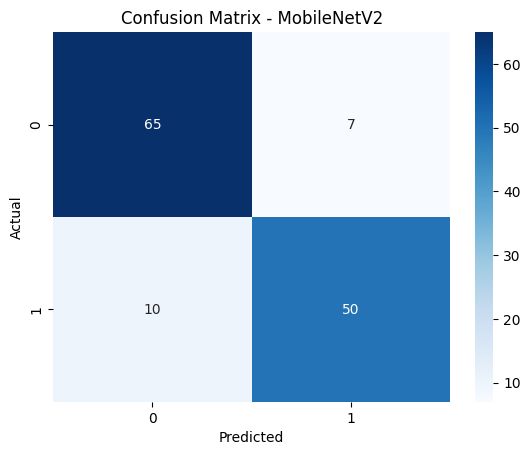

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = mobilenet_model.predict(val_images)
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print("Classification Report for MobileNetV2:\n")
print(classification_report(val_labels, predicted_labels))

# Confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6. Improved Method – DenseNet121

In [14]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Split the dataset
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# 2. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True
)
datagen.fit(train_images)

# 3. Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# 4. Load and Fine-Tune DenseNet121
IMG_SIZE = (224, 224)
densenet_base = DenseNet121(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

# Fine-tune last layers
densenet_base.trainable = True
for layer in densenet_base.layers[:-20]:
    layer.trainable = False

x = densenet_base.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

densenet_model = Model(inputs=densenet_base.input, outputs=output)

# 5. Compile
densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('densenet_best.h5', save_best_only=True)

# 7. Train
densenet_history = densenet_model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(val_images, val_labels),
    epochs=25,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6448 - loss: 0.6599

17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.6495 - loss: 0.6548 - val_accuracy: 0.8788 - val_loss: 0.2967
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8212 - loss: 0.3788

17/17 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.8225 - loss: 0.3777 - val_accuracy: 0.8636 - val_loss: 0.2757
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.8820 - loss: 0.3039 - val_accuracy: 0.8182 - val_loss: 0.3091
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.9009 - loss: 0.2421 - val_accuracy: 0.8258 - val_loss: 0.2862
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.9269 - loss: 0.1927 - val_accuracy: 0.8485 - val_loss: 0.3664
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - accuracy: 0.9227 - loss: 0.1788 - val_accuracy: 0.8561 - val_loss: 0.3687
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.9612 - loss: 0.1232 - val_accuracy: 0.8636 - val_loss: 0.3189


## 7. Evaluation – DenseNet121

5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step
Classification Report for DenseNet121:

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        72
           1       0.84      0.87      0.85        60

    accuracy                           0.86       132
   macro avg       0.86      0.86      0.86       132
weighted avg       0.86      0.86      0.86       132



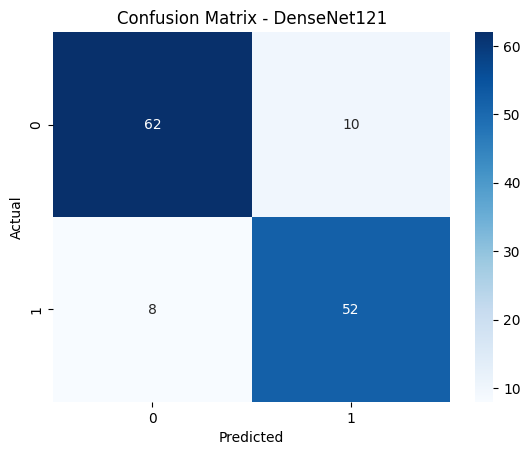

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
predictions = densenet_model.predict(val_images)
predicted_labels = (predictions > 0.5).astype(int)

print("Classification Report for DenseNet121:\n")
print(classification_report(val_labels, predicted_labels, zero_division=1))

cm = confusion_matrix(val_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 📊 7. Comparison and Final Notes


MobileNetV2 Accuracy:
Validation Accuracy: 87.0%

Average Precision: 87.0% (Class 0: 87%, Class 1: 88%)

Average Recall: 87.0% (Class 0: 90%, Class 1: 83%)

Average F1-Score: 87.0% (Class 0: 88%, Class 1: 85%)

Strengths: Balanced performance across both classes with strong precision and recall. Fast and lightweight.

Minor Weakness: Slight drop in recall for class 1.

DenseNet121 Accuracy:
Validation Accuracy: 86.0%

Average Precision: 86.5% (Class 0: 89%, Class 1: 84%)

Average Recall: 86.5% (Class 0: 86%, Class 1: 87%)

Average F1-Score: 86.0% (Class 0: 87%, Class 1: 85%)

Strengths: Very balanced results. High performance on malignant class (recall = 87%).

Slightly Slower: Training takes longer than MobileNetV2 due to deeper architecture.

### Conclusion:
Best Model:  MobileNetV2 (slightly better overall accuracy, strong across all metrics)

Runner-Up:  DenseNet121 (excellent balance, stronger on class 1)

Drop:  EfficientNetB0 (unreliable performance, should not be used as final model)


## 8. Visual Results – Segmentation

Total images found: 660

Showing The First Five Images
Showing: 1269.jpg


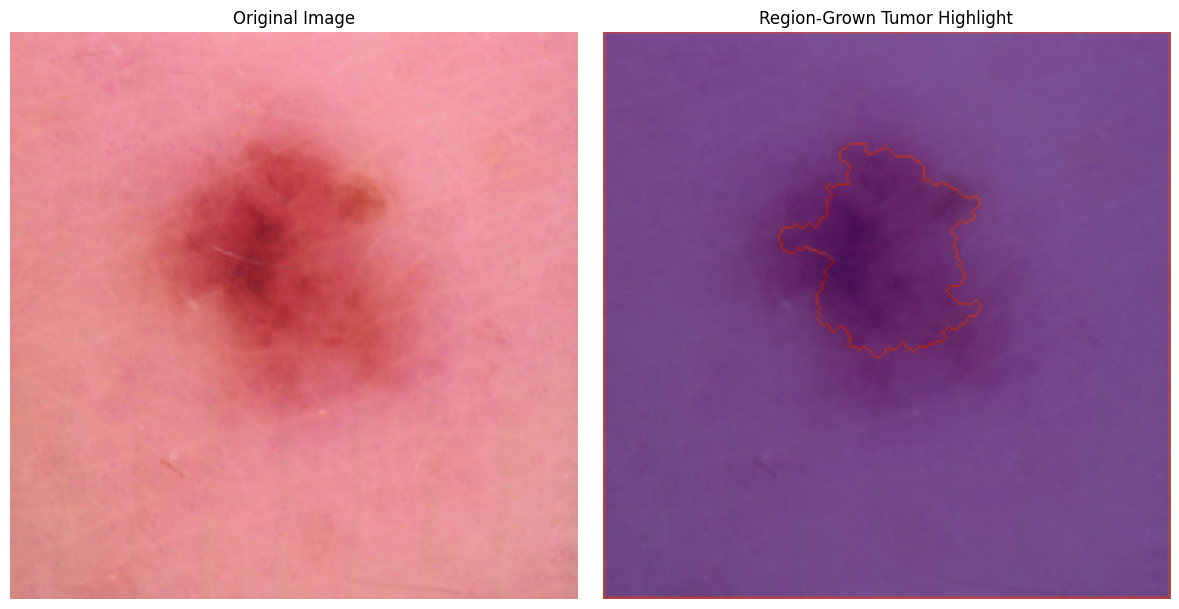

Showing: 623.jpg


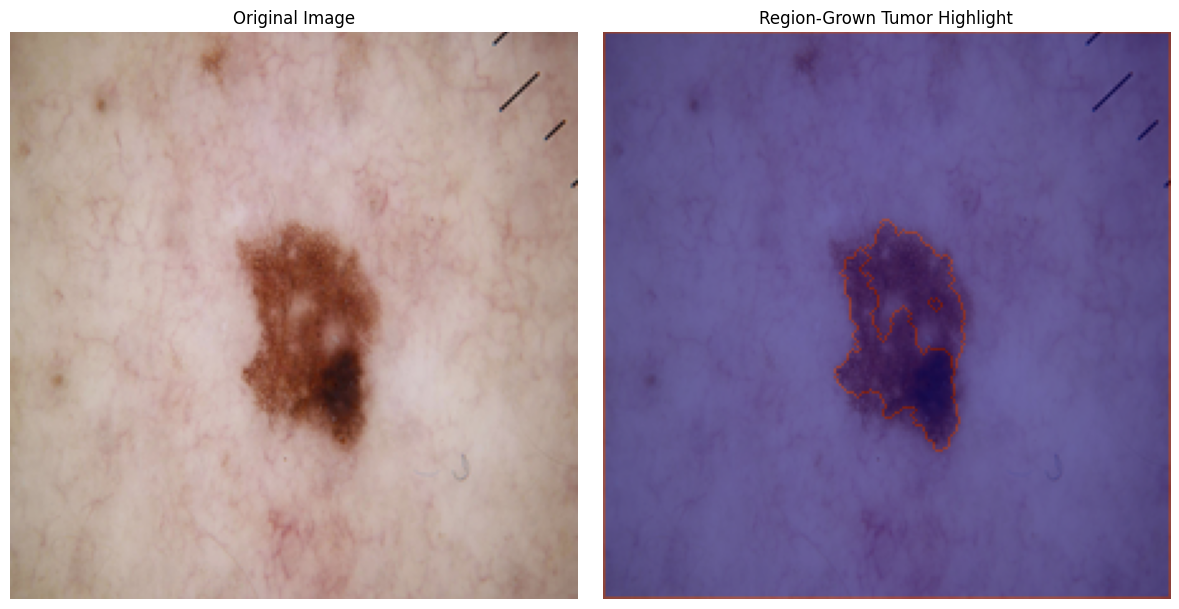

Showing: 820.jpg


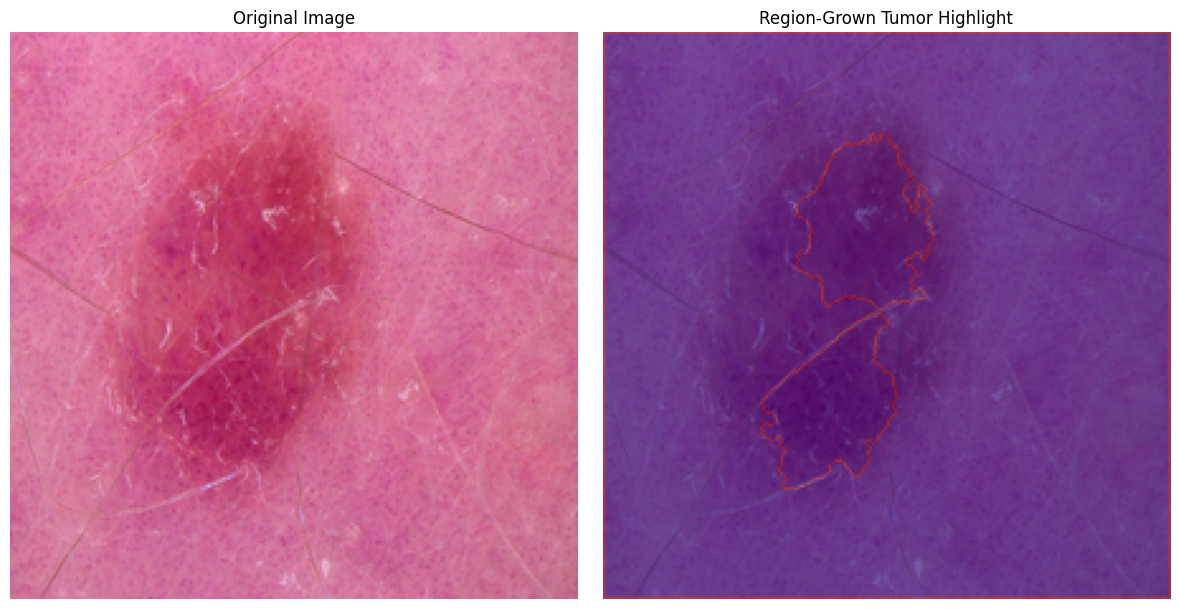

Showing: 1354.jpg


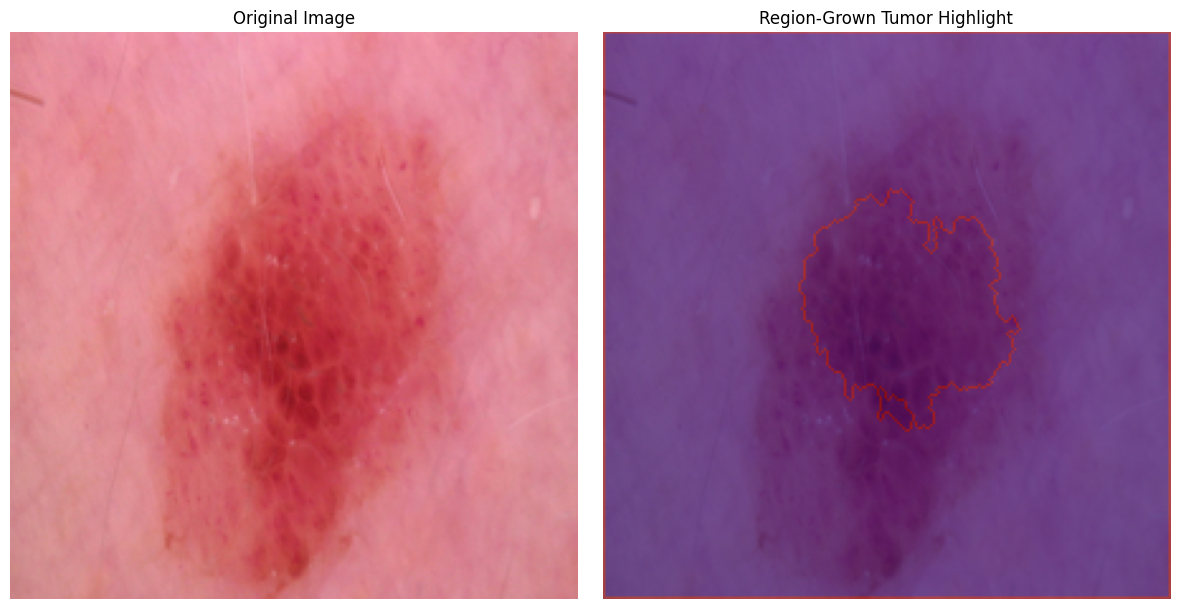

Showing: 45.jpg


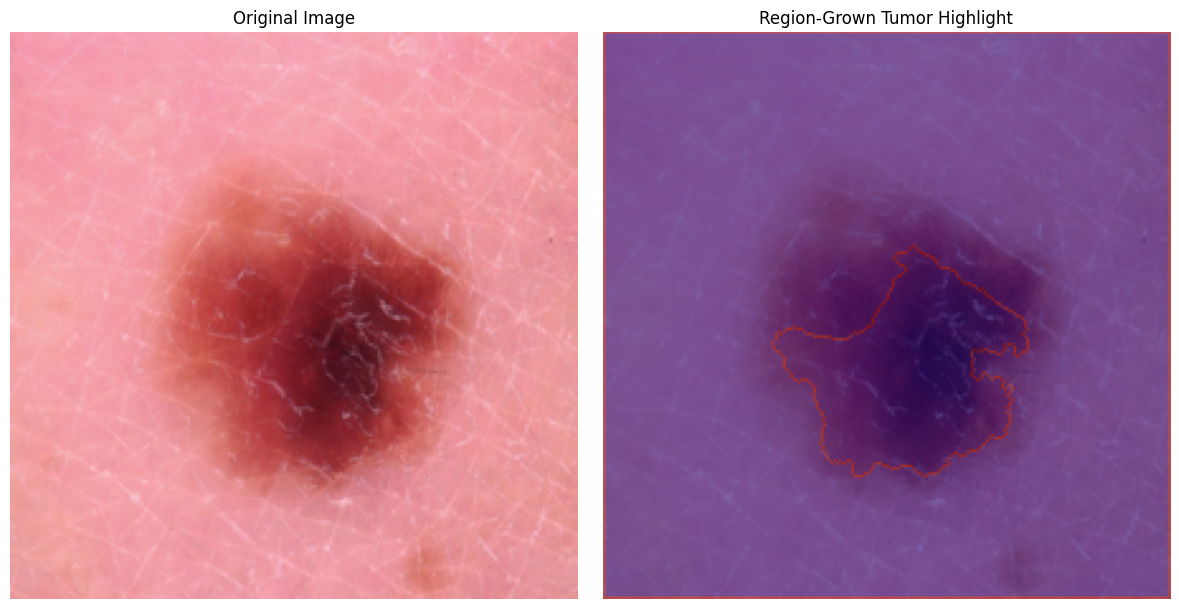

In [16]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Set base path to the benign and malignant folders
base_path_benign = "/kaggle/input/skin-cancer-malignant-vs-benign/test/benign"
base_path_malignant = "/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant"

def collect_image_paths(base_path):
    image_paths = []
    for filename in os.listdir(base_path):
        if filename.lower().endswith(('.jpg', '.png')) and "_segmentation" not in filename.lower():
            image_paths.append(os.path.join(base_path, filename))
    return image_paths

# Collect paths for both benign and malignant images
image_paths_benign = collect_image_paths(base_path_benign)
image_paths_malignant = collect_image_paths(base_path_malignant)

# Combine both sets of paths
image_paths = image_paths_benign + image_paths_malignant

# Region-Growing Watershed Method
def apply_region_growth(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Binary threshold
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal (morphology)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure Background Area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Sure Foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker Labeling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Increment to notice the difference from the background
    markers[unknown == 255] = 0

    # Apply Watershed
    result = cv2.watershed(image, markers)
    segmented = np.uint8((result == -1) * 255)  # boundary map

    return image_rgb, segmented

# Process and display all images (benign + malignant)
print(f"Total images found: {len(image_paths)}\n")
print(f"Showing The First Five Images")

for i in range(5):  # Limit to 5 images
    img_path = image_paths[i]
    original, segmented = apply_region_growth(img_path)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(original)
    plt.imshow(segmented, cmap="jet", alpha=0.5)
    plt.title("Region-Grown Tumor Highlight")
    plt.axis("off")

    plt.tight_layout()
    print(f"Showing: {os.path.basename(img_path)}")
    plt.show()
